# Wines Points prediction 

In [157]:
%load_ext autoreload
%autoreload 2
#imports:
import cufflinks as cf; cf.go_offline()
from datetime import date
import emoji
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
from pandas import DataFrame
import pandas as pd
import pickle
import re as regex
from scipy.sparse import coo_matrix, hstack
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from src.models import i_feel_lucky_xgboost_training
import string
import sys; sys.path.append('../')
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [2]:
import pandas as pd
import cufflinks as cf; cf.go_offline()

In [3]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_reviews.shape

(129971, 14)

In [4]:
wine_reviews.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
90821,90821,US,"An immense wine, inky purple, packed with blac...",Big Papa Old Block,93,49.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Efeste 2008 Big Papa Old Block Cabernet Sauvig...,Cabernet Sauvignon,Efeste
122628,122628,Australia,Big butterscotch—aromas and flavors—come close...,Giants Creek,84,17.0,New South Wales,Hunter Valley,NaN,Joe Czerwinski,@JoeCz,Rosemount 1999 Giants Creek Chardonnay (Hunter...,Chardonnay,Rosemount
45676,45676,France,"A wine that tastes of its granite soil, very l...",NaN,88,24.0,France Other,Patrimonio,NaN,Roger Voss,@vossroger,Clos Teddi 2008 Nielluciu (Patrimonio),Nielluciu,Clos Teddi
116587,116587,Italy,"Aromas of pressed blue flower, spiced plum and...",San Martino,90,52.0,Tuscany,Bolgheri Superiore,NaN,Kerin O’Keefe,@kerinokeefe,Cipriana 2011 San Martino (Bolgheri Superiore),Red Blend,Cipriana
109705,109705,US,"This is a classic Napa Valley floor Cabernet, ...",Estate Grown,89,60.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Grgich Hills 2011 Estate Grown Cabernet Sauvig...,Cabernet Sauvignon,Grgich Hills


## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [5]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])
wine_reviews = wine_reviews.drop_duplicates()
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [6]:
len(test_data), len(train_data)

(23998, 95990)

### Baselines

In [8]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [9]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.406251
MAE    2.513368
R2    -0.000090
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [10]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.605629
Armenia                   88.000000
Australia                 88.503398
Austria                   90.117768
Bosnia and Herzegovina    86.500000
Name: points, dtype: float64

In [11]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    8.926484
MAE    2.446500
R2     0.050920
dtype: float64

### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [12]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.729598
           Other               85.869880
Armenia    Armenia             88.000000
Australia  Australia Other     85.603352
           New South Wales     87.718750
Name: basiline_3_predicted_points, dtype: float64

In [13]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 16), (23998, 15))

In [14]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.380137
MAE    2.352921
R2     0.109008
dtype: float64

### Baselines summary

In [15]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.406251,2.513368,-0.000090
baseline_2,8.926484,2.446500,0.050920
baseline_3,8.380137,2.352921,0.109008


In [16]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [17]:
le = LabelEncoder()

#### Preparing data - Lable encoding categorical features

In [18]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [19]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87


#### Re-splitting to train and test

In [20]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

#### Fitting a tree-regressor

In [22]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 2 to 129970
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int32  
 1   province     95990 non-null  int32  
 2   region_1     95990 non-null  int32  
 3   region_2     95990 non-null  int32  
 4   taster_name  95990 non-null  int32  
 5   variety      95990 non-null  int32  
 6   winery       95990 non-null  int32  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int32(7), int64(1)
memory usage: 4.8 MB


In [23]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [24]:
test_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points,xgb_clf_points_prediction
0,22,332,424,6,9,691,11608,-1.0,87,87
1,32,108,738,6,16,451,12956,15.0,87,87
4,41,269,1218,17,15,441,14621,65.0,87,92
6,22,332,1205,6,9,186,15014,16.0,87,87
8,17,308,738,6,1,209,8415,12.0,87,87


In [25]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

MSE    6.205267
MAE    1.891741
R2     0.340245
dtype: float64

In [26]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

,MSE,MAE,R2
baseline_1,9.406251,2.513368,-0.000090
baseline_2,8.926484,2.446500,0.050920
baseline_3,8.380137,2.352921,0.109008
regression_by_xgb,6.205267,1.891741,0.340245


In [27]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

# My part

## Bag of words

In [29]:
specialChars = ''.join([",", ":", "\"", "=", "&", ";", "%", "$","@", "%", "^", "*", "(", ")", "{", "}",'–','“', '”'
                      "[", "]", "|", "/", "\\", ">", "<", "-","!", "?", ".", "'","--", "---", "#", '‘', '’', '…'])  
space_chars = ['.',',',';', '&', '?','!']
def remove_by_regex(tweets, regexp):
    return tweets.replace(regexp, "")

def remove_urls(tweets):
    return remove_by_regex(tweets, regex.compile(r"http\S+"))

def remove_special_chars(tweets): 
    return tweets.apply(lambda tweet: ''.join([c for c in tweet if c not in specialChars]))

def remove_usernames(tweets):
    return remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

def remove_numbers(tweets):
    return remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

def remove_emojis(tweets):
    return tweets.apply(lambda tweet: ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI))

def add_spaces(tweets):
    def add_spaces_int(tweet):
        for char in space_chars:
            tweet = tweet.replace(char, char + ' ')
        return tweet
    return tweets.apply(lambda tweet: add_spaces_int(tweet))

def leave_language_only(tweets):
    for f in [remove_urls, remove_emojis, add_spaces, remove_numbers, remove_usernames, remove_special_chars]:
        tweets = f(tweets)
    return tweets

In [30]:
wine_reviews['pureDesc'] = leave_language_only(wine_reviews.description.str.lower())
wine_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                119929 non-null  object 
 1   description            119988 non-null  object 
 2   designation            85443 non-null   object 
 3   points                 119988 non-null  int64  
 4   price                  111593 non-null  float64
 5   province               119929 non-null  object 
 6   region_1               100428 non-null  object 
 7   region_2               46769 non-null   object 
 8   taster_name            95071 non-null   object 
 9   taster_twitter_handle  90542 non-null   object 
 10  title                  119988 non-null  object 
 11  variety                119987 non-null  object 
 12  winery                 119988 non-null  object 
 13  pureDesc               119988 non-null  object 
dtypes: float64(1), int64(1), object(12)


Cleaning up the english description - mainly removing numbers, punctuation etc.

In [31]:
wine_reviews[['description','pureDesc']].sample()

,description,pureDesc
61312,Ripe oaky aromas include prune and raisin scen...,ripe oaky aromas include prune and raisin scen...


In [32]:
stopwords=nltk.corpus.stopwords.words("english")
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [33]:
nltk.word_tokenize(wine_reviews.pureDesc.iloc[0])

['aromas',
 'include',
 'tropical',
 'fruit',
 'broom',
 'brimstone',
 'and',
 'dried',
 'herb',
 'the',
 'palate',
 'isnt',
 'overly',
 'expressive',
 'offering',
 'unripened',
 'apple',
 'citrus',
 'and',
 'dried',
 'sage',
 'alongside',
 'brisk',
 'acidity']

Cleaning up stopwords and setting up the train for the bow model:

In [34]:
all_words_train = [word for desc in wine_reviews[wine_reviews.index.isin(train_data.index)].pureDesc for word in nltk.word_tokenize(desc) if word.lower() not in stopwords] # Words without stop words
all_words = [word for desc in wine_reviews.pureDesc for word in nltk.word_tokenize(desc) if word.lower() not in stopwords] # Words without stop words
words_train_df = DataFrame(data = all_words_train, columns = ['word']).word.value_counts().reset_index()
words_train_df.columns = ['word','wordCount']
words_train_df['wordImportance'] = len(words_train_df) / words_train_df.wordCount / words_train_df.wordCount.max()
words_train_df.head()

,word,wordCount,wordImportance
0,wine,57613,0.000012
1,flavors,46373,0.000015
2,fruit,33301,0.000021
3,aromas,28981,0.000024
4,palate,27737,0.000025


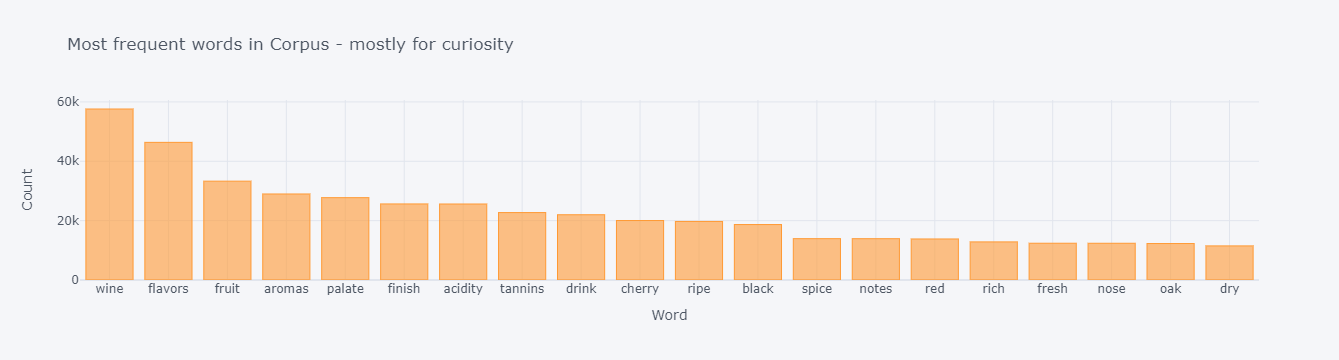

In [35]:
words_train_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus - mostly for curiosity', yTitle = 'Count', xTitle = 'Word')

In [36]:
print("Total of {} words, {} unique words".format(len(all_words_train), len(words_train_df)))

Total of 2364183 words, 40304 unique words


Like the tweets example - We'll drop any word which has under 4 appearances:

In [153]:
print ("Using words with 4 or more appearances will reduce the corpus size to: {}".format(sum(words_train_df.wordCount >= 4)))

Using words with 4 or more appearances will reduce the corpus size to: 13357


In [38]:
words_train_df = words_train_df[words_train_df.wordCount >= 4]

Starting the encoding:

In [39]:
le = LabelEncoder()

In [40]:
clean_vocab_train = set(words_train_df.word)
count_vect_train = CountVectorizer(vocabulary = clean_vocab_train, tokenizer=nltk.word_tokenize)
clean_bow_counts_train = count_vect_train.fit_transform(wine_reviews[wine_reviews.index.isin(train_data.index)].pureDesc)
clean_bow_counts_train.shape

(95990, 13357)

In [41]:
wine_reviews.iloc[0].pureDesc

'aromas include tropical fruit  broom  brimstone and dried herb  the palate isnt overly expressive  offering unripened apple  citrus and dried sage alongside brisk acidity '

In [42]:
tf_idf_vectorizer = TfidfVectorizer(vocabulary = clean_vocab_train)
bow_tfidf = tf_idf_vectorizer.fit_transform(wine_reviews.pureDesc)
bow_tfidf_train = tf_idf_vectorizer.fit_transform(wine_reviews[wine_reviews.index.isin(train_data.index)].pureDesc)
bow_tfidf_train.shape

(95990, 13357)

In [45]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
mse_by_alpha = []
for alpha in search_grid:
    bow_ridge_model = Ridge(alpha=alpha)
    avg_score = cross_val_score(bow_ridge_model, clean_bow_counts_train, y = wine_reviews[wine_reviews.index.isin(train_data.index)].points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    mse_by_alpha.append((alpha, abs(avg_score)))

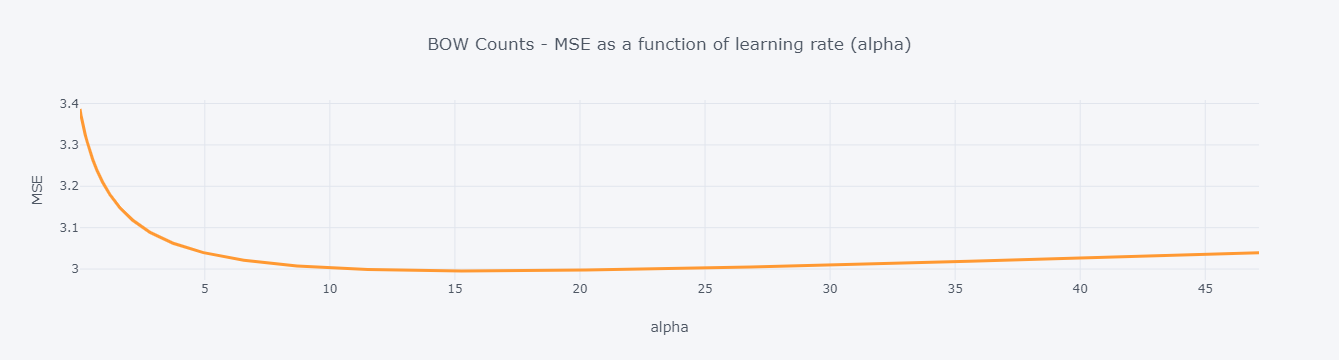

In [46]:
cv_results_bow = DataFrame(mse_by_alpha, columns = ['alpha', 'MSE'])
cv_results_bow.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of learning rate (alpha)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [47]:
opt_alpha_bow, min_mse = cv_results_bow.loc[cv_results_bow.MSE.idxmin(),:'MSE']
print(opt_alpha_bow, min_mse)

15.264179671752334 2.9952893652333334


### Optimal Model

Let's use the optimal model regularization parameter and train a model on the **entire dataset**:

In [48]:
bow_ridge_model = Ridge(alpha=opt_alpha_bow, max_iter=10000)
clean_bow_counts = count_vect_train.fit_transform(wine_reviews.pureDesc)
bow_ridge_model.fit(clean_bow_counts, wine_reviews.points)

Ridge(alpha=15.264179671752334, max_iter=10000)

In [49]:
wine_reviews['predicted_score_bow'] = bow_ridge_model.predict(clean_bow_counts)

In [50]:
wine_reviews.predicted_score_bow = wine_reviews.apply(lambda row: round(row.predicted_score_bow), axis=1)
# wine_reviews.sample(10)
accuracy_score(wine_reviews.predicted_score_bow, wine_reviews.points)

0.2516668333500017

In [51]:
bow_stats = calc_prediction_quality(wine_reviews, 'predicted_score_bow', 'points')

In [52]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, bow_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb','predicted_score_bow'])
all_compared

,MSE,MAE,R2
baseline_1,9.406251,2.513368,-0.000090
baseline_2,8.926484,2.446500,0.050920
baseline_3,8.380137,2.352921,0.109008
regression_by_xgb,6.205267,1.891741,0.340245
predicted_score_bow,2.657149,1.245658,0.722231


### Using tfidf:

In [53]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
scores_by_alpha = []
for alpha in search_grid:
    bow_tfidf_ridge_model = Ridge(alpha=alpha)
    mse_by_alpha = abs(cross_val_score(bow_tfidf_ridge_model, bow_tfidf, y = wine_reviews.points, cv = 10, scoring = 'neg_mean_squared_error').mean())
    ase_by_alpha = abs(cross_val_score(bow_tfidf_ridge_model, bow_tfidf, y = wine_reviews.points, cv = 10, scoring = 'neg_mean_absolute_error').mean())
    r2_by_alpha = cross_val_score(bow_tfidf_ridge_model, bow_tfidf, y = wine_reviews.points, cv = 10, scoring = 'r2').mean()
    scores_by_alpha.append((alpha,mse_by_alpha,ase_by_alpha,r2_by_alpha))

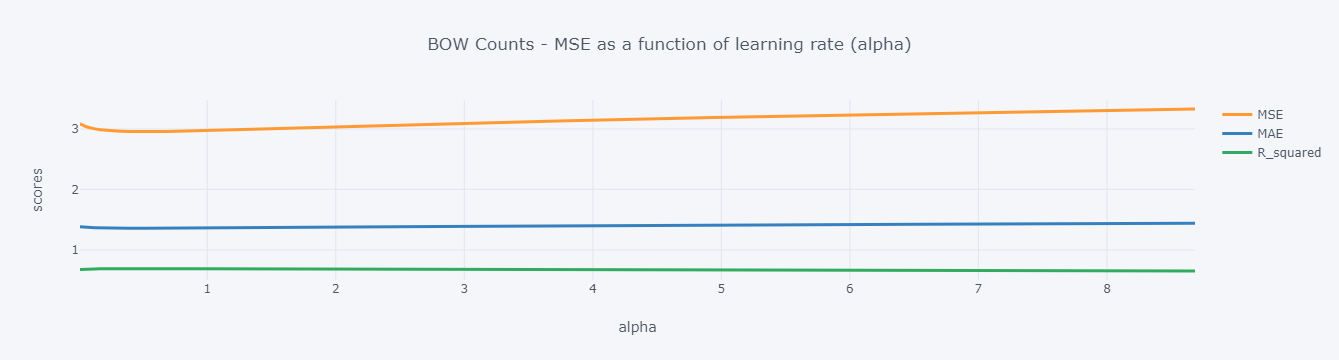

In [54]:
cv_results = DataFrame(scores_by_alpha, columns = ['alpha', 'MSE','MAE','R_squared'])
cv_results.query('alpha < 10').set_index('alpha').iplot(title = 'BOW Counts - MSE as a function of learning rate (alpha)', xTitle = 'alpha', yTitle = 'scores', width = 3, hline=(0,0))

In [55]:
# cv_results.head()
opt_alpha_bow_tfidf, min_mse = cv_results.loc[cv_results.MSE.idxmin(),:'MSE']
print(opt_alpha_bow_tfidf, min_mse)

0.517947467923121 2.955489890935179


### Optimal Model

Let's use the optimal model regularization parameter and train a model on the **entire dataset**:

In [56]:
bow_tfidf_ridge_model = Ridge(alpha=opt_alpha_bow_tfidf, max_iter=10000)
bow_tfidf_ridge_model.fit(bow_tfidf, wine_reviews.points)

Ridge(alpha=0.517947467923121, max_iter=10000)

In [57]:
wine_reviews['predicted_score_bow_tfidf_ridge'] = bow_tfidf_ridge_model.predict(bow_tfidf)

In [58]:
wine_reviews.predicted_score_bow_tfidf_ridge = wine_reviews.apply(lambda row: round(row.predicted_score_bow_tfidf_ridge), axis=1)
# wine_reviews.sample(10)
accuracy_score(wine_reviews.predicted_score_bow_tfidf_ridge, wine_reviews.points)

0.25914258092475917

In [59]:
clean_bow_stats = calc_prediction_quality(wine_reviews, 'predicted_score_bow_tfidf_ridge', 'points')

In [60]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, bow_stats, clean_bow_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb','predicted_score_bow','clean_bow_ridge'])
all_compared

,MSE,MAE,R2
baseline_1,9.406251,2.513368,-0.000090
baseline_2,8.926484,2.446500,0.050920
baseline_3,8.380137,2.352921,0.109008
regression_by_xgb,6.205267,1.891741,0.340245
predicted_score_bow,2.657149,1.245658,0.722231
clean_bow_ridge,2.504017,1.206821,0.738239


In [61]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Neural Networks

### LSTM

In [155]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [64]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [66]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_data.description.to_numpy())

In [69]:
lstm_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

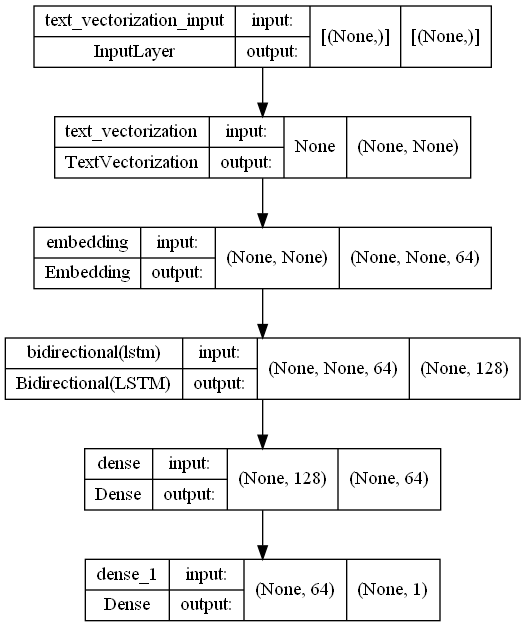

In [70]:
tf.keras.utils.plot_model(lstm_model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [ ]:
lstm_model.summary()

In [71]:
lstm_model.compile(loss=tf.keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['mean_absolute_error'])

In [72]:
%%time
early_stopping_monitor = EarlyStopping(
    monitor='mean_absolute_error',
    min_delta=0.01,
    patience=2,
    verbose=1,
    restore_best_weights=True)
history = lstm_model.fit(train_data.description, train_data.points, epochs=10,
                    validation_data = (test_data.description, test_data.points),
                    callbacks=[early_stopping_monitor],
                    verbose=1,
                    batch_size=128)

Epoch 1/10
750/750 [==============================] - 160s 204ms/step - loss: 35.9325 - mean_absolute_error: 35.9325 - val_loss: 2.4890 - val_mean_absolute_error: 2.4890
Epoch 2/10
750/750 [==============================] - 151s 202ms/step - loss: 2.5065 - mean_absolute_error: 2.5065 - val_loss: 2.4580 - val_mean_absolute_error: 2.4580
Epoch 3/10
750/750 [==============================] - 150s 200ms/step - loss: 1.9878 - mean_absolute_error: 1.9878 - val_loss: 1.5654 - val_mean_absolute_error: 1.5654
Epoch 4/10
750/750 [==============================] - 134s 179ms/step - loss: 1.5160 - mean_absolute_error: 1.5160 - val_loss: 1.4777 - val_mean_absolute_error: 1.4777
Epoch 5/10
750/750 [==============================] - 135s 180ms/step - loss: 1.4667 - mean_absolute_error: 1.4667 - val_loss: 1.4637 - val_mean_absolute_error: 1.4637
Epoch 6/10
750/750 [==============================] - 136s 182ms/step - loss: 1.4442 - mean_absolute_error: 1.4442 - val_loss: 1.4636 - val_mean_absolute_erro

In [73]:
test_loss, test_acc = lstm_model.evaluate(test_data.description, test_data.points)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

750/750 [==============================] - 10s 13ms/step - loss: 1.4087 - mean_absolute_error: 1.4087
Test Loss: 1.4086930751800537
Test Accuracy: 1.4086930751800537


(0.0, 37.65920681357384)

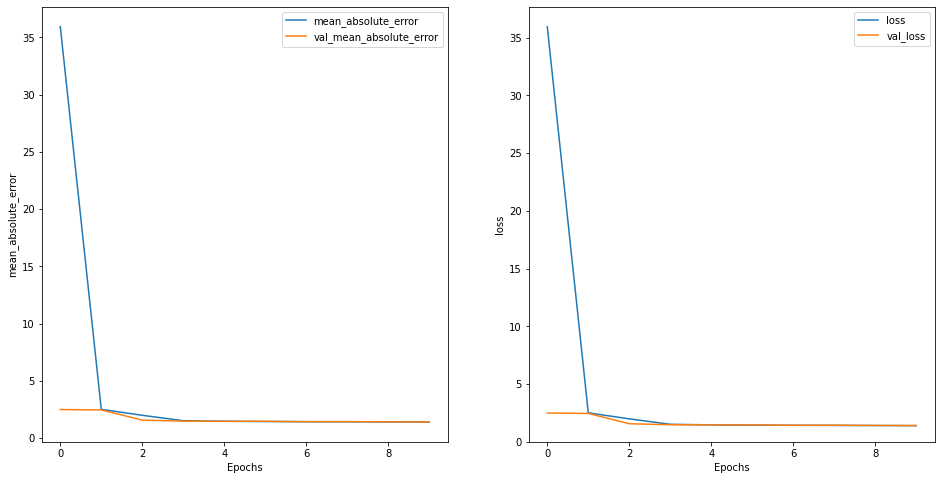

In [74]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'mean_absolute_error')
# plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [75]:
wine_reviews['predicted_score_lstm'] = lstm_model.predict(wine_reviews.description)

In [76]:
wine_reviews.predicted_score_lstm = wine_reviews.apply(lambda row: round(row.predicted_score_lstm), axis=1)
# wine_reviews.sample(10)
accuracy_score(wine_reviews.predicted_score_lstm, wine_reviews.points)

0.24207420742074207

In [77]:
lstm_stats = calc_prediction_quality(wine_reviews, 'predicted_score_lstm', 'points')

In [78]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, clean_bow_stats, lstm_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb','clean_bow_ridge', 'predicted_score_lstm'])
all_compared

,MSE,MAE,R2
baseline_1,9.406251,2.513368,-0.000090
baseline_2,8.926484,2.446500,0.050920
baseline_3,8.380137,2.352921,0.109008
regression_by_xgb,6.205267,1.891741,0.340245
clean_bow_ridge,2.504017,1.206821,0.738239
predicted_score_lstm,3.360219,1.357369,0.648735


In [79]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

### Pre-trained word embeddings

In [81]:
vectorizer = tf.keras.layers.TextVectorization(max_tokens=20000, output_sequence_length=200)
vectorizer.adapt(train_data.description.to_numpy())

In [82]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [83]:
path_to_glove_file = "data/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [84]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 14838 words (5162 misses)


In [85]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=num_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [86]:
pretrained_embed_lstm_model = tf.keras.Sequential([
    vectorizer,
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
pretrained_embed_lstm_model.summary()

In [87]:
pretrained_embed_lstm_model.compile(loss=tf.keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['mean_absolute_error'])

In [88]:
%%time
early_stopping_monitor = EarlyStopping(
    monitor='mean_absolute_error',
    min_delta=0.01,
    patience=2,
    verbose=1,
    restore_best_weights=True)
history_pretrained = pretrained_embed_lstm_model.fit(train_data.description, train_data.points, epochs=10,
                    validation_data = (test_data.description, test_data.points),
                    callbacks=[early_stopping_monitor],
                    verbose=1,
                    batch_size=128)

Epoch 1/10
750/750 [==============================] - 362s 479ms/step - loss: 41.3524 - mean_absolute_error: 41.3524 - val_loss: 2.5131 - val_mean_absolute_error: 2.5131
Epoch 2/10
750/750 [==============================] - 344s 458ms/step - loss: 2.5374 - mean_absolute_error: 2.5374 - val_loss: 2.5082 - val_mean_absolute_error: 2.5082
Epoch 3/10
750/750 [==============================] - 349s 465ms/step - loss: 2.5322 - mean_absolute_error: 2.5322 - val_loss: 2.5026 - val_mean_absolute_error: 2.5026
Epoch 4/10
750/750 [==============================] - 380s 506ms/step - loss: 2.4824 - mean_absolute_error: 2.4824 - val_loss: 2.1064 - val_mean_absolute_error: 2.1064
Epoch 5/10
750/750 [==============================] - 384s 511ms/step - loss: 1.9179 - mean_absolute_error: 1.9179 - val_loss: 1.7541 - val_mean_absolute_error: 1.7541
Epoch 6/10
750/750 [==============================] - 390s 520ms/step - loss: 1.7063 - mean_absolute_error: 1.7063 - val_loss: 1.6542 - val_mean_absolute_erro

In [89]:
test_loss, test_acc = pretrained_embed_lstm_model.evaluate(test_data.description, test_data.points)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

750/750 [==============================] - 39s 52ms/step - loss: 1.5573 - mean_absolute_error: 1.5573
Test Loss: 1.557259202003479
Test Accuracy: 1.557259202003479


(0.0, 43.34218691587448)

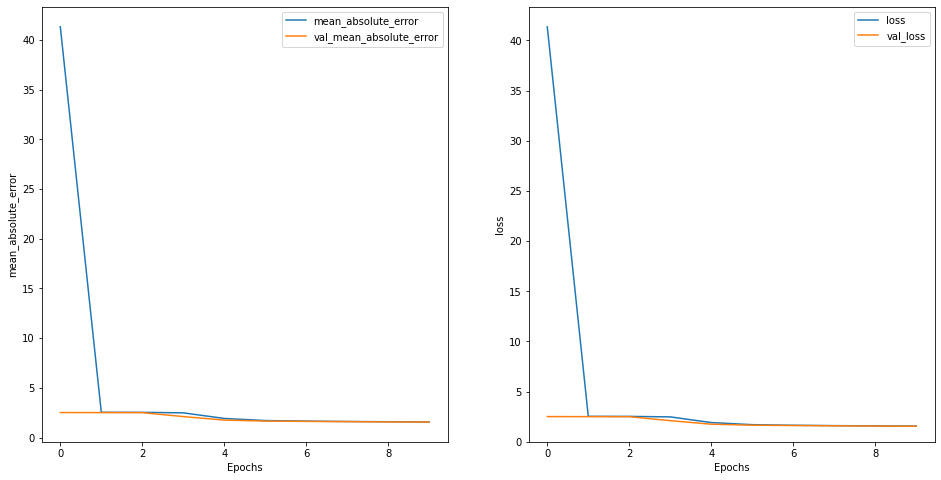

In [90]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_pretrained, 'mean_absolute_error')
# plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_pretrained, 'loss')
plt.ylim(0, None)

In [91]:
wine_reviews['predicted_score_lstm_pretrained'] = pretrained_embed_lstm_model.predict(wine_reviews.description)

In [92]:
wine_reviews.predicted_score_lstm_pretrained = wine_reviews.apply(lambda row: round(row.predicted_score_lstm_pretrained), axis=1)
accuracy_score(wine_reviews.predicted_score_lstm_pretrained, wine_reviews.points)

0.20902923625695902

In [93]:
lstm_pretrained_stats = calc_prediction_quality(wine_reviews, 'predicted_score_lstm_pretrained', 'points')

In [94]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, clean_bow_stats, lstm_stats,lstm_pretrained_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb','clean_bow_ridge', 'predicted_score_lstm','predicted_score_lstm_pretrained'])
all_compared

,MSE,MAE,R2
baseline_1,9.406251,2.513368,-0.000090
baseline_2,8.926484,2.446500,0.050920
baseline_3,8.380137,2.352921,0.109008
regression_by_xgb,6.205267,1.891741,0.340245
clean_bow_ridge,2.504017,1.206821,0.738239
predicted_score_lstm,3.360219,1.357369,0.648735
predicted_score_lstm_pretrained,3.967955,1.533428,0.585204


In [95]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Adding numerical features to model:

In [127]:
scaler = StandardScaler()

encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]


train_scaled_encoded_features = scaler.fit_transform(train_encoded_features.loc[:,train_encoded_features.columns!='points'])
train_scaled_encoded_features = pd.DataFrame(train_scaled_encoded_features, columns=train_encoded_features.loc[:,train_encoded_features.columns!='points'].columns)

test_scaled_encoded_features = scaler.transform(test_encoded_features.loc[:,test_encoded_features.columns!='points'])
test_scaled_encoded_features = pd.DataFrame(test_scaled_encoded_features, columns=test_encoded_features.loc[:,test_encoded_features.columns!='points'].columns)

scaled_encoded_features = scaler.transform(encoded_features.loc[:,encoded_features.columns!='points'])
scaled_encoded_features = pd.DataFrame(scaled_encoded_features, columns=encoded_features.loc[:,encoded_features.columns!='points'].columns)

#### Re-splitting to train and test

In [128]:
train_features_spares_matrix = coo_matrix(train_scaled_encoded_features)
train_united_features = hstack((clean_bow_counts_train ,train_features_spares_matrix))

features_spares_matrix = coo_matrix(encoded_features)
united_features = hstack((clean_bow_counts ,features_spares_matrix))

In [130]:
%%capture
%%time
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
mse_by_alpha_numerical_plus = []
for alpha in search_grid:
    bow_tfidf_ridge_model_plus_num = Ridge(alpha=alpha)
    mse_by_alpha = abs(cross_val_score(bow_tfidf_ridge_model_plus_num, train_united_features, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean())
    ase_by_alpha = abs(cross_val_score(bow_tfidf_ridge_model_plus_num, train_united_features, y = train_data.points, cv = 10, scoring = 'neg_mean_absolute_error').mean())
    r2_by_alpha = cross_val_score(bow_tfidf_ridge_model_plus_num, train_united_features, y = train_data.points, cv = 10, scoring = 'r2').mean()
    mse_by_alpha_numerical_plus.append((alpha,mse_by_alpha,ase_by_alpha,r2_by_alpha))

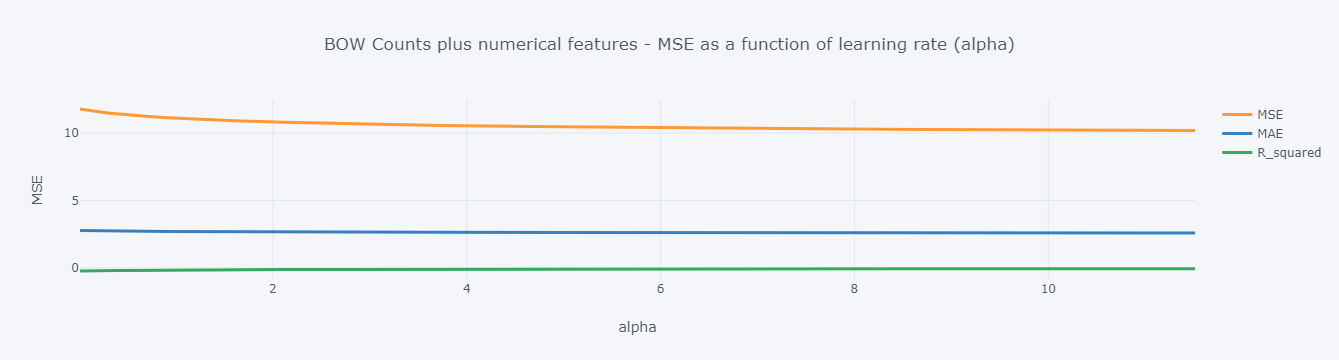

In [131]:
cv_results_bow_plus_num = DataFrame(mse_by_alpha_numerical_plus, columns = ['alpha', 'MSE','MAE','R_squared'])
cv_results_bow_plus_num.query('alpha < 15').set_index('alpha').iplot(title = 'BOW Counts plus numerical features - MSE as a function of learning rate (alpha)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [132]:
opt_alpha_bow_plus_num, min_mse = cv_results_bow_plus_num.loc[cv_results_bow_plus_num.MSE.idxmin(),:'MSE']
print(opt_alpha_bow_plus_num, min_mse)

10000.0 9.610318406187163


In this case obviously the model is flawed, but we'll continue for curiosity's sake:

### Optimal Model

Let's use the optimal model regularization parameter and train a model on the **entire dataset**:

In [133]:
opt_bow_tfidf_ridge_model_plus_num = Ridge(alpha=opt_alpha_bow_plus_num, max_iter=10000)
opt_bow_tfidf_ridge_model_plus_num.fit(united_features, wine_reviews.points)

Ridge(alpha=10000.0, max_iter=10000)

In [134]:
wine_reviews['predicted_score_bow_tfidf_ridge_plus_num'] = opt_bow_tfidf_ridge_model_plus_num.predict(united_features)

In [135]:
wine_reviews.predicted_score_bow_tfidf_ridge_plus_num = wine_reviews.apply(lambda row: round(row.predicted_score_bow_tfidf_ridge_plus_num), axis=1)
# wine_reviews.sample(10)
accuracy_score(wine_reviews.predicted_score_bow_tfidf_ridge_plus_num, wine_reviews.points)

0.16145781244791146

In [136]:
ridge_plus_num_stats = calc_prediction_quality(wine_reviews, 'predicted_score_bow_tfidf_ridge_plus_num', 'points')

In [137]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, clean_bow_stats, lstm_stats,lstm_pretrained_stats,ridge_plus_num_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb','clean_bow_ridge', 'predicted_score_lstm','predicted_score_lstm_pretrained','ridge-plus_numerical'])
all_compared

,MSE,MAE,R2
baseline_1,9.406251,2.513368,-0.000090
baseline_2,8.926484,2.446500,0.050920
baseline_3,8.380137,2.352921,0.109008
regression_by_xgb,6.205267,1.891741,0.340245
clean_bow_ridge,2.504017,1.206821,0.738239
predicted_score_lstm,3.360219,1.357369,0.648735
predicted_score_lstm_pretrained,3.967955,1.533428,0.585204
ridge-plus_numerical,5.685627,1.888264,0.405645


In [156]:
datestr = date.today().strftime("%d.%m.%Y")
all_compared.to_pickle(f"all_results_{datestr}")

In [138]:
#saving models:
pickle.dump(bow_ridge_model, open('bow_ridge_model.pkl', 'wb'))
pickle.dump((opt_alpha_bow, opt_alpha_bow_tfidf, opt_alpha_bow_plus_num), open('optimal_alphas.pkl', 'wb'))
pickle.dump(bow_tfidf_ridge_model, open('bow_tfidf_ridge_model.pkl', 'wb'))
pickle.dump(bow_tfidf_ridge_model_plus_num, open('bow_tfidf_ridge_model_plus_num.pkl', 'wb'))
pickle.dump(opt_bow_tfidf_ridge_model_plus_num, open('opt_bow_tfidf_ridge_model_plus_num.pkl', 'wb'))
pretrained_embed_lstm_model.save("data/models/pretrained_embed_lstm_model")


lstm_model.save("data/models/lstm_model") #saved



INFO:tensorflow:Assets written to: data/models/pretrained_embed_lstm_model\assets


INFO:tensorflow:Assets written to: data/models/pretrained_embed_lstm_model\assets


INFO:tensorflow:Assets written to: data/models/lstm_model\assets


INFO:tensorflow:Assets written to: data/models/lstm_model\assets


In [ ]:
# loading models:

# lstm_model = keras.models.load_model("data/models/lstm_model")
# bow_ridge_model = pickle.load(open('bow_ridge_model.pkl', 'rb'))
# bow_tfidf_ridge_model = pickle.load(open('bow_tfidf_ridge_model.pkl', 'rb'))